In [1]:
import numpy as np
import matplotlib.pyplot as plt
import function as func
import os
import lmfit
import math
from scipy import integrate

In [2]:
def fit_func(x, y, height, mean_x, mean_y, sigma, base):
    return height * np.exp( - np.power((x-mean_x)/sigma, 2.)/2) * np.exp( - np.power((y-mean_y)/sigma, 2.)/2) + base

def residual(params, x, y, z, ze, base):
    height = params['height']
    mean_x = params['mean_x']
    mean_y = params['mean_y']
    sigma = params['sigma']

    y_model = fit_func(x, y, height, mean_x, mean_y, sigma, base)

    chi = (z - y_model)/ze
    o = np.isfinite(chi)
    return chi[o]

In [3]:
def fit_3D(x, y, z, ze, base, ax):
    params = lmfit.Parameters()

    params.add('height', value=1.5e-5)
    params.add('mean_x', value=0., vary=False)
    params.add('mean_y', value=0., vary=False)
    params.add('sigma', value=0.2)
    
    result = lmfit.minimize(residual, params, args=(x, y, z, ze, base))

    h = result.params["height"].value
    mx = result.params["mean_x"].value
    my = result.params["mean_y"].value
    mxe = result.params["mean_x"].stderr
    mye = result.params["mean_y"].stderr
    s = np.abs(result.params["sigma"].value)
    se = result.params["sigma"].stderr
    
    z = fit_func(x, y, h, mx, my, s, base)

    ax.errorbar(x, y, z, zerr = 0, fmt="x", markersize=5, color="r", label="fit result")
    
    return z, mx, my, mxe, mye, s, se

In [4]:
def plot_Aeff(f, ax):   
    path = "/data/ms2840a/other_data/Aeff/data_not_used/Aeff_"
    path = "/data/ms2840a/other_data/Aeff/data/Aeff_"
    point = ["m40", "m30", "m20", "m15", "m10", "m5", "m4", "m3", "m2", "m1", "0", "p1", "p2", "p3", "p4", "p5", "p10", "p15", "p20", "p30", "p40"]
    point = ["m40", "m30", "m20", "m15", "m10", "m5", "m2", "0", "p2", "p5", "p10", "p15", "p20", "p30", "p40"]
    #point = ["m40", "m30", "m20", "m15", "m10", "m5", "0", "p5", "p10", "p15", "p20", "p30", "p40"]
    #point = ["m20", "m15", "m10", "m5", "0", "p5", "p10", "p15", "p20"]

    
    x = []
    y = []
    z = []
    ze = []
    base = []
    for i in point:
        if i == "0": num_x = 0.
        if "m" in i: num_x = -1. * float(i[1:]) * 0.01
        if "p" in i: num_x = float(i[1:]) * 0.01

        for j in point:
            if j == "0": num_y = 0.
            if "m" in j: num_y = -1. * float(j[1:]) * 0.01
            if "p" in j: num_y = float(j[1:]) * 0.01

            file0 = path + i + "_" + j + "_{}GHz_0.dat".format(f)
            file1 = path + i + "_" + j + "_{}GHz_1.dat".format(f)

            if os.path.exists(file0) and os.path.exists(file1):
                f0, W0 = func.dat_to_array(file0)
                f1, W1 = func.dat_to_array(file1)
                
                #if not ("20" in i or "30" in i or "40" in i or "20" in j or "30" in j or "40" in j):
                #if not ("30" in i or "40" in i or "30" in j or "40" in j):
                x.append(num_x)
                y.append(num_y)
                z.append((np.max(W0)+np.max(W1))/2)
                ze.append(np.std(np.array([np.max(W0), np.max(W1)])))
                
                if "30" in i or "40" in i or "30" in j or "40" in j:
                    base.append((np.max(W0)+np.max(W1))/2)

    x = np.array(x)
    y = np.array(y)
    z = np.array(z/np.max(z))
    ze = np.array(ze)
    base = np.mean(np.array(base))

    ax.errorbar(x, y, z, zerr = ze, capsize=0, fmt='x', markersize=5, ecolor="blue", markeredgecolor="blue", color="blue", label="data")

    ax.view_init(elev=0, azim=0)
    #ax.view_init(elev=10, azim=90)
    
    ax.set_xlabel("x [m] (polarized direction)")
    ax.set_ylabel("y [m]")
    ax.set_zlabel("Power [W]")
    #ax.set_xticks([-0.4, -0.2, 0, 0.2, 0.4])
    #ax.set_yticks([-0.4, -0.2, 0, 0.2, 0.4])
    ax.legend()
    ax.set_title("{} GHz".format(f))
    
    
    zf, mx, my, mxe, mye, s, se = fit_3D(x, y, z, ze, base, ax)
    #print(round(mx*1000,2), round(mxe*1000,2), round(my*1000,2), round(mye*1000,2))
    #print(round(s*100,3), round(se*100,3))
    
    C = 4*np.sqrt(np.log(2))
    deg = C * math.degrees(np.arctan(s/1.25))
    deg_e = C * se / (1 + (s/1.25)**2)
    #print("theta = " + str(2*round(deg,2)) + "pm" +  str(2*round(deg_e,2)))
    
    return mx, my, s, se, deg, deg_e


[1.12100407e-01 1.05321022e+02 8.45857272e-02 7.41906224e-02
 1.07002614e-01]


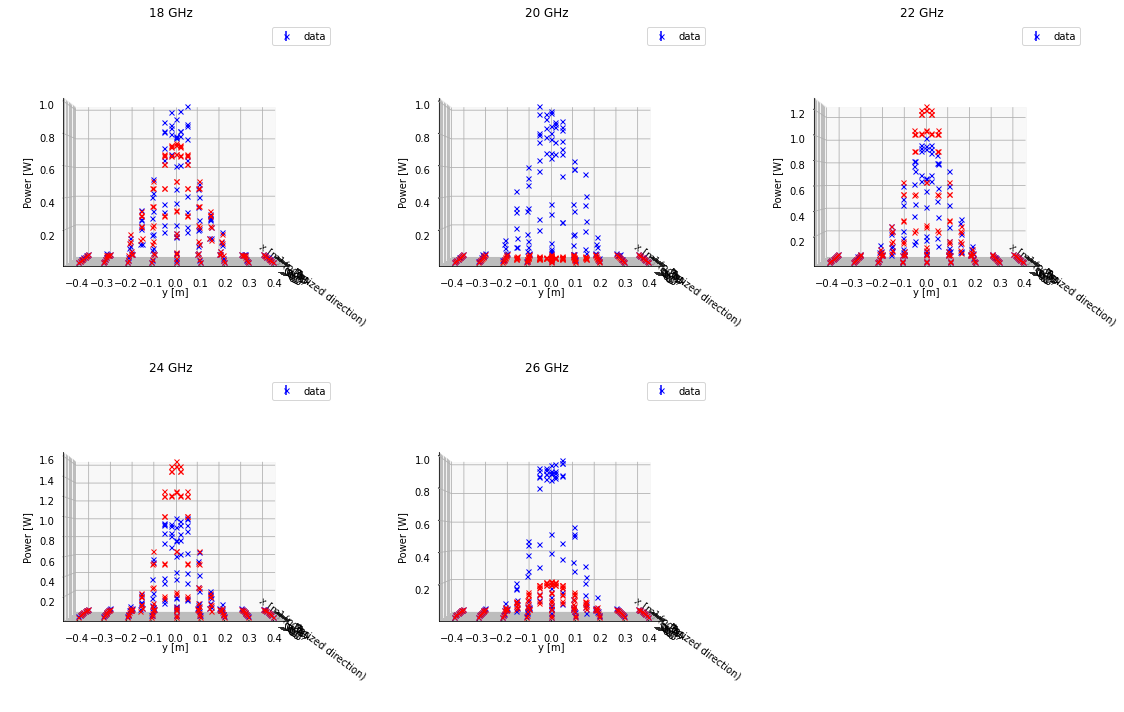

In [41]:
mx_array = []
my_array = []
sigma_measure = []
sigma_e_measure = []
hpbw_measure = []
hpbw_e_measure = []

plt.rcParams["font.size"] = 10
fig, axes = plt.subplots(2,3,figsize=(16,10),subplot_kw=dict(projection='3d'))

mx, my, sig, sig_e, deg, deg_e = plot_Aeff(18, axes[0][0])
mx_array.append(mx)
my_array.append(my)
sigma_measure.append(sig)
sigma_e_measure.append(sig_e)
hpbw_measure.append(deg)
hpbw_e_measure.append(deg_e)

mx, my, sig, sig_e, deg, deg_e = plot_Aeff(20, axes[0][1])
mx_array.append(mx)
my_array.append(my)
sigma_measure.append(sig)
sigma_e_measure.append(sig_e)
hpbw_measure.append(deg)
hpbw_e_measure.append(deg_e)

mx, my, sig, sig_e, deg, deg_e = plot_Aeff(22, axes[0][2])
mx_array.append(mx)
my_array.append(my)
sigma_measure.append(sig)
sigma_e_measure.append(sig_e)
hpbw_measure.append(deg)
hpbw_e_measure.append(deg_e)

mx, my, sig, sig_e, deg, deg_e = plot_Aeff(24, axes[1][0])
mx_array.append(mx)
my_array.append(my)
sigma_measure.append(sig)
sigma_e_measure.append(sig_e)
hpbw_measure.append(deg)
hpbw_e_measure.append(deg_e)

mx, my, sig, sig_e, deg, deg_e = plot_Aeff(26, axes[1][1])
mx_array.append(mx)
my_array.append(my)
sigma_measure.append(sig)
sigma_e_measure.append(sig_e)
hpbw_measure.append(deg)
hpbw_e_measure.append(deg_e)

axes[-1, -1].axis('off')

sigma_measure = np.array(sigma_measure)
sigma_e_measure = np.array(sigma_e_measure)
hpbw_measure = np.array(hpbw_measure)
hpbw_e_measure = np.array(hpbw_e_measure)

print(sigma_measure)

fig.tight_layout()
#plt.savefig("../result_figure/A_eff/fit_result.pdf")

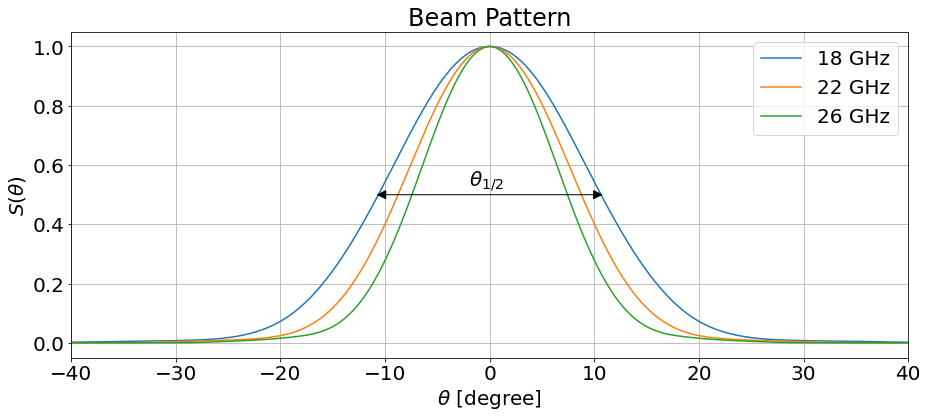

In [2]:
data = func.csv_to_array("/data/ms2840a/other_data/Aeff/Aeff_gain.csv")

plt.rcParams["font.size"] = 20
plt.figure(figsize=(15,6))

#for freq in ["18GHz", "19GHz", "20GHz", "21GHz", "22GHz", "23GHz", "24GHz", "25GHz", "26GHz"]:
for freq in ["18GHz", "22GHz", "26GHz"]:
    for pol in ["0deg"]:
        W = np.concatenate([np.flip(data[freq+pol]), data[freq+pol][1:]], 0)
        theta = np.concatenate([np.flip(data["theta"]) * -1, data["theta"][1:]], 0)
        #plt.plot(theta, np.power(10, W/10), label=freq[:2] + " GHz")
        plt.plot(theta, np.power(10, W/10)/np.max(np.power(10, W/10)), label=freq[:2] + " GHz")
        

plt.annotate('', xy=[-11, 0.5], xytext=[11, 0.5],
            arrowprops=dict(arrowstyle='<|-|>', 
                            connectionstyle='arc3', 
                            facecolor='black', 
                            edgecolor='black')
           )
plt.text(-2, 0.53, r"$\theta_{1/2}$")
        
plt.title("Beam Pattern")
plt.xlabel(r"$\theta$ [degree]")
plt.ylabel(r"$S(\theta)$")
plt.legend()
plt.xlim([-40,40])
#plt.ylim([-10,175])
plt.grid()

#plt.savefig("../result_figure/A_eff/beam_pattern.pdf")
#plt.savefig("../result_figure/slide_figure/beam_pattern.pdf")

21.2
20.2
19.2
18.2
17.4
16.6
15.8
15.2
14.8


(0.0, 30.0)

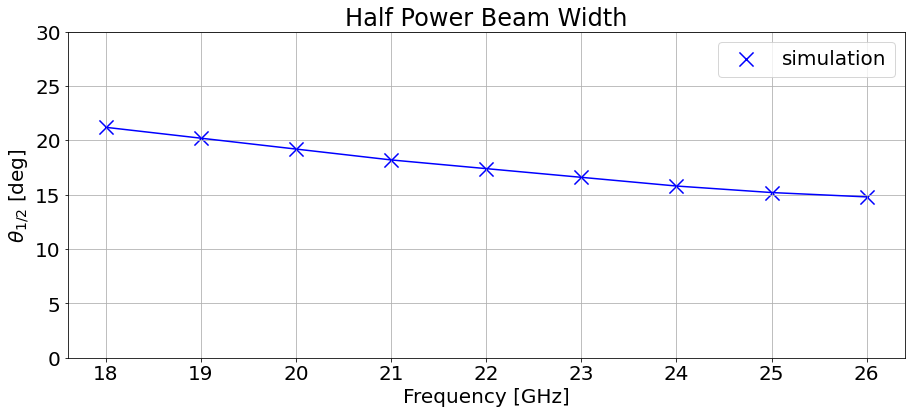

In [6]:
hpbw_sim = []
point = np.array([18, 19, 20, 21, 22, 23, 24, 25, 26])
for freq in ["18GHz", "19GHz", "20GHz", "21GHz", "22GHz", "23GHz", "24GHz", "25GHz", "26GHz"]:
    for pol in ["0deg"]:
        W = 10**(data[freq+pol]/10)
        for i in range(len(W)):
            if W[i] >= W[0]/2 and W[i+1] <= W[0]/2:
                hpbw_sim.append(data["theta"][i]*2)
                print(data["theta"][i]*2)
                break
                
hpbw_sim = np.array(hpbw_sim)
freq_measure = np.array([18,20,22,24,26])

plt.rcParams["font.size"] = 20
plt.figure(figsize=(15,6))
plt.plot(point, hpbw_sim, color="blue")
plt.scatter(point, hpbw_sim, label="simulation", marker="x", s=200, color="blue")
#plt.errorbar(freq_measure, hpbw_measure, yerr=hpbw_e_measure, capsize=0, fmt='x', markersize=15, ecolor='red', markeredgecolor = "red", color='red', label="measurement")
plt.title("")
plt.xlabel("Frequency [GHz]")
plt.ylabel(r"$\theta_{1/2}$ [deg]")
plt.title("Half Power Beam Width")
plt.grid()
plt.legend()
plt.ylim([0,30])
#plt.savefig("../result_figure/A_eff/HPBW.pdf")

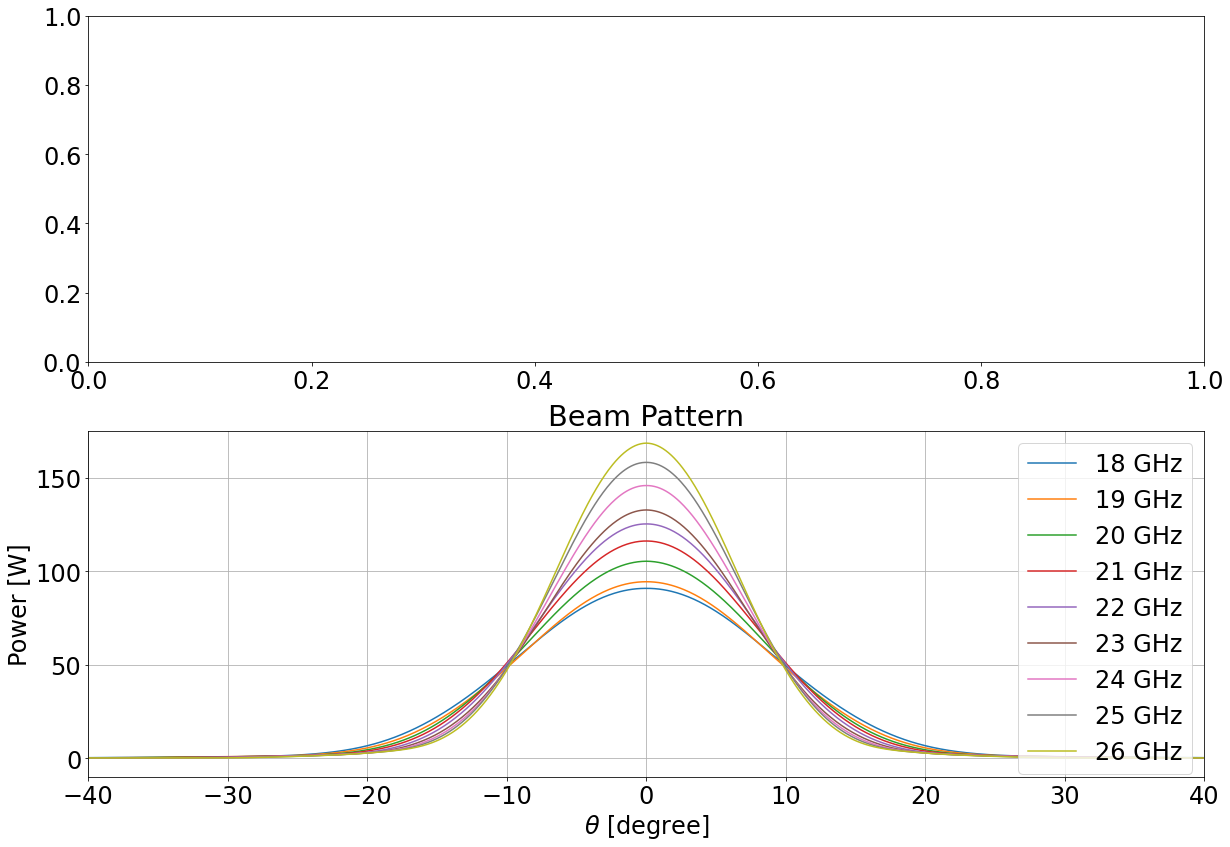

In [24]:
plt.rcParams["font.size"] = 24
fig, axes = plt.subplots(2,1,figsize=(20,14), squeeze=False, sharex=False)

ax = axes[0][0]
for freq in ["18GHz", "19GHz", "20GHz", "21GHz", "22GHz", "23GHz", "24GHz", "25GHz", "26GHz"]:
    for pol in ["0deg"]:
        W = np.concatenate([np.flip(data[freq+pol]), data[freq+pol][1:]], 0)
        theta = np.concatenate([np.flip(data["theta"]) * -1, data["theta"][1:]], 0)
        plt.plot(theta, np.power(10, W/10), label=freq[:2] + " GHz")
        
plt.title("Beam Pattern")
plt.xlabel(r"$\theta$ [degree]")
plt.ylabel("Power [W]")
plt.legend()
plt.xlim([-40,40])
plt.ylim([-10,175])
plt.grid()

In [25]:
y = lambda x: np.exp(-x**2/2)/np.sqrt(2*np.pi)

# yを0からpiまで数値積分
integ = integrate.quad(y, -np.inf, np.inf)

print(integ)

(0.9999999999999998, 1.0178191320905743e-08)


In [26]:
def fit_line(x, a, b):
    return a * (x-22) + b

def residual_line(params, x, y, ye):
    a = params['a']
    b = params['b']
    y_model = fit_line(x, a, b)
    chi = (y - y_model)/ye
    o = np.isfinite(chi)
    return chi[o]

def fit_Neff_line(x, y, ye):    
    params = lmfit.Parameters()
    params.add('a', value=1.)
    params.add('b', value=1.)

    result = lmfit.minimize(residual_line, params, args=(x, y, ye))
    a = result.params["a"].value
    ae = result.params["a"].stderr
    b = result.params["b"].value
    be = result.params["b"].stderr
    
    print("a = " + str(round(a, 6)) + " +/- " + str(round(ae, 6)))
    print("b = " + str(round(b, 6)) + " +/- " + str(round(be, 6)))
    
    return fit_line(x, a, b), ((ae*x)**2 + be**2)**0.5

In [27]:
Omega_A = []
for freq in ["18GHz", "19GHz", "20GHz", "21GHz", "22GHz", "23GHz", "24GHz", "25GHz", "26GHz"]:
    W = 10**(data[freq+"0deg"]/10)
    Omega_A.append(integral(data["theta"], (W/np.max(W))) * 2 * np.pi)
        
A_antenna = np.pi * (59.3/2*1e-3)**2
c = 299792458. # [m/sec] speed of light from wikipedia
eta = (c/(point*1e+9))**2/np.array(Omega_A)/A_antenna

plt.figure(figsize=(15,6))
plt.scatter(point, eta, marker="x", s=200, color="blue", label="simulation")

print(np.mean(eta), np.std(eta))
plt.text(24.1, 0.25, r"$\eta$ = " + str(round(np.mean(eta), 2)) + r"$\pm$" + str(round(np.std(eta),2)))
plt.plot([18, 26], [0.629, 0.629], color="red", label="constant")

plt.grid()
plt.legend()
plt.xlabel("Frequency [GHz]")
plt.ylabel(r"$\eta$")
plt.title(r"$\eta = A_{\rm eff}/A$")
plt.ylim([0,1])
plt.savefig("../result_figure/A_eff/eta_fit.pdf")

NameError: name 'integral' is not defined

In [28]:
print(data["theta"])

[0.000e+00 1.000e-01 2.000e-01 ... 1.798e+02 1.799e+02 1.800e+02]


In [29]:
def gausian(x, mean, sigma, height):
    return height * np.exp( - np.power((x-mean)/sigma, 2)/2)

In [30]:
Omega_A = []
for _s in hpbw/2:
    value = gausian(data["theta"], 0, _s, 1)**2 * sin_int * 2 * np.pi
    Omega_A.append(integrate.simps(value, np.radians(data["theta"])))

Omega_A_measure = []
for _s in hpbw_measure/2:
    value = gausian(data["theta"], 0, _s, 1)**2 * sin_int * 2 * np.pi
    Omega_A_measure.append(integrate.simps(value, np.radians(data["theta"])))

    
Omega_A = np.array(Omega_A)
Omega_A_measure = np.array(Omega_A_measure)

A_antenna = np.pi * (59.3/2*1e-3)**2 # [m^2]
c = 299792458. # [m/sec] speed of light from wikipedia

eta = (c/point/1e+9)**2/Omega_A/A_antenna
eta_measure = (c/freq_measure/1e+9)**2/Omega_A_measure/A_antenna


plt.figure(figsize=(15,6))
plt.scatter(point, eta, marker="x", s=200, color="blue", label="simulation")
plt.scatter(freq_measure, eta_measure, marker="x", s=200, color="green", label="measurement")
#plt.plot([18,26], [0.467, 0.467], color="red", label="constant")

plt.grid()
plt.legend()
#plt.ylim([-0.05,1.05])
plt.xlabel("Frequency [GHz]")
plt.title(r"$\eta = A_{\rm eff}/A$")


print(np.mean(eta), np.std(eta))
check = np.abs(np.array([eta[0]-eta_measure[0], eta[2]-eta_measure[1], eta[4]-eta_measure[2], eta[6]-eta_measure[3], eta[8]-eta_measure[4]]))

print(np.std(check))

plt.text(22.1, 0.25, r"$\eta$ = " + str(round(np.mean(eta), 3)) + r" $\pm$ " + str(round(np.std(eta),3)) + r"(stat) $\pm$ " + str(round(np.std(check),3)) + "(syst)")



NameError: name 'hpbw' is not defined

In [34]:
L = 1.0865 # [m] the length between anntena and window
radius = 0.105 # [m] the radius of window
theta_win = np.degrees(np.arctan(radius/L)) # [deg] 
        
Omega_win = []
for freq in ["18GHz", "19GHz", "20GHz", "21GHz", "22GHz", "23GHz", "24GHz", "25GHz", "26GHz"]:
    W = 10**(data[freq+"0deg"]/10)
    _th = data["theta"][:int(theta_win*10)]
    _W = W[:int(theta_win*10)]
    Omega_win.append(integral(_th, _W/np.max(W)) * 2 * np.pi)

Omega_win = np.array(Omega_win)
epsilon = Omega_win/Omega_A
        
plt.figure(figsize=(15,6))
plt.scatter(point, epsilon, marker="x", color="blue", s=200, label="simulation")

y, ye = fit_Neff_line(point, Omega_win/Omega_A, 1)
plt.plot(point, y, color="red", label="linear fit")
plt.grid()
plt.legend()
plt.ylim([0,1])
plt.xlabel("Frequency [GHz]")
plt.ylabel(r"$\epsilon_{\rm win}$")
plt.title(r"$\epsilon_{\rm win} = \Omega_{\rm win}/\Omega_{\rm A}$")

#plt.text(18.1, 0.7, r"$\epsilon_{\rm win} = 0.23 \pm 0.00$")
#plt.text(18.6, 0.6, r"$+ ~(0.017 \pm 0.000)(\nu - 22 ~{\rm GHz})$")
plt.savefig("../result_figure/A_eff/epsilon_fit.pdf")


ValueError: operands could not be broadcast together with shapes (9,) (0,) 

NameError: name 'eta' is not defined

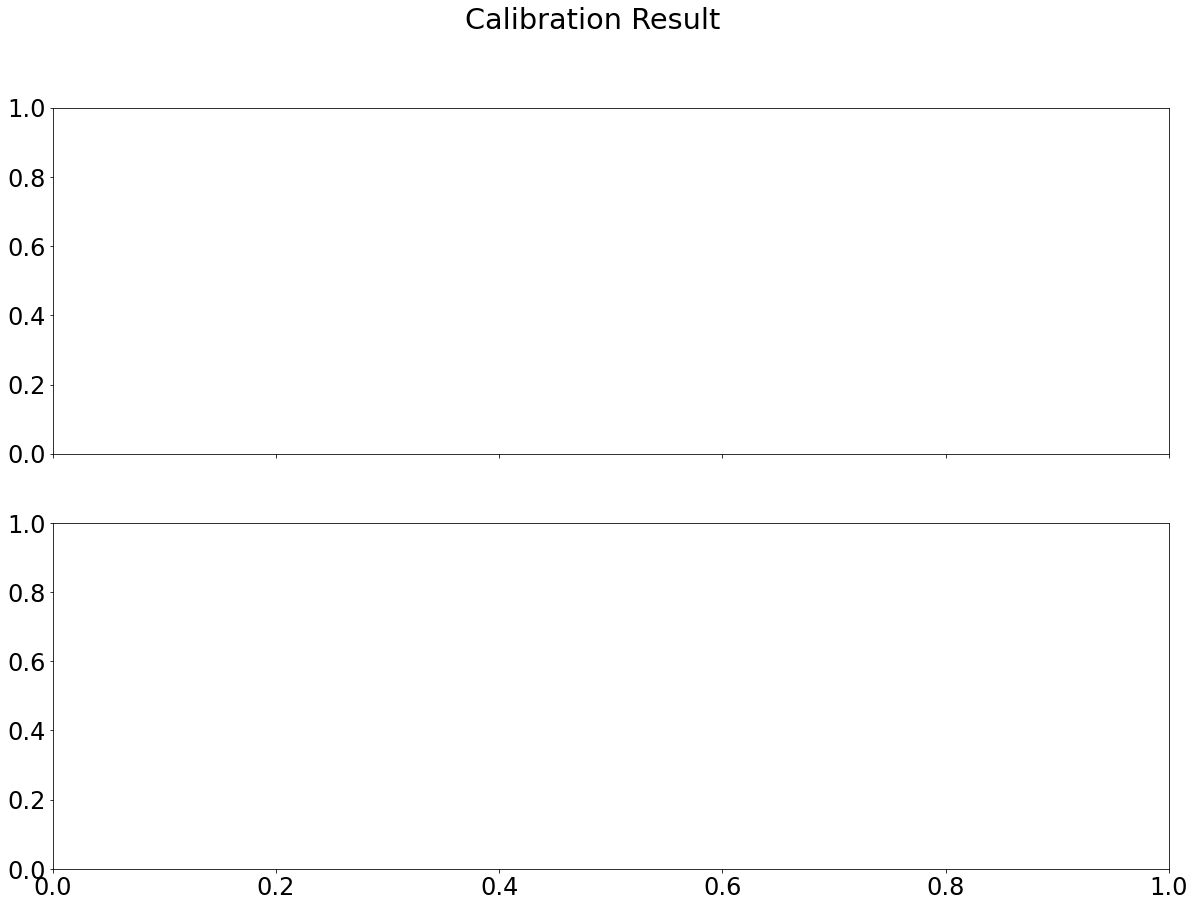

In [32]:
plt.rcParams["font.size"] = 24
fig, axes = plt.subplots(2,1,figsize=(20,14), squeeze=False, sharex=True)
plt.suptitle("Calibration Result")

ax = axes[0][0]
#ax.set_title("Calibration Result")
ax.scatter(point, eta, marker="x", s=300, color="blue", label="simulation")
ax.scatter(freq_measure, eta_measure, marker="x", s=300, color="green", label="measurement")
ax.plot([18,26], [0.467, 0.467], color="red", label="constant")
ax.grid()
ax.legend()
ax.set_ylim([0,1])
ax.set_ylabel(r"$\eta = A_{\rm eff}/A$")
check = np.abs(np.array([eta[0]-eta_measure[0], eta[2]-eta_measure[1], eta[4]-eta_measure[2], eta[6]-eta_measure[3], eta[8]-eta_measure[4]]))
ax.text(22.1, 0.25, r"$\eta$ = " + str(round(np.mean(eta), 3)) + r" $\pm$ " + str(round(np.std(eta),3)) + r"(stat) $\pm$ " + str(round(np.std(check),3)) + "(syst)")


ax = axes[1][0]
e_win = Omega_win/Omega_A
e_win_measure = Omega_win_measure/Omega_A_measure
ax.scatter(point, e_win, marker="x", color="blue", s=300, label="simulation")
ax.scatter(freq_measure, e_win_measure, marker="x", color="green", s=300, label="measurement")
y, ye = fit_Neff_line(point, Omega_win/Omega_A, 1)
ax.plot(point, y, color="red", label="linear fit")
ax.grid()
ax.legend()
ax.set_ylim([0,1])
ax.set_xlabel("Frequency [GHz]")
ax.set_ylabel(r"$\epsilon_{\rm win} = \Omega_{\rm win}/\Omega_{\rm A}$")

check = np.abs(np.array([e_win[0]-e_win_measure[0], e_win[2]-e_win_measure[1], e_win[4]-e_win_measure[2], e_win[6]-e_win_measure[3], e_win[8]-e_win_measure[4]]))
ax.text(18.1, 0.7, r"$\epsilon_{\rm win} = 0.322 \pm 0.001 {\rm (stat)}$")
ax.text(18.6, 0.6, r"$+ ~(0.024 \pm 0.0004 {\rm (stat)})(\nu - 22 ~{\rm GHz})$")
ax.text(18.6, 0.5, r"$\pm$ " + str(round(np.std(check),3)) + "(syst)")

#plt.savefig("../result_figure/A_eff/eta_epsilon.pdf")

In [3]:
def gauss(theta, sigma):
    return np.exp(-8*np.log(2)*theta**2/2/sigma**2)

def my_func(freq, value):
    result = 0
    for i in range(1800):
        f = np.radians((freq[i] + freq[i+1])/2)
        s = (value[i] + value[i+1])/2
        result += s**2 * np.sin(f) * np.radians(0.1)
    return result

def integral(freq, s):
    value = s * np.sin(np.radians(freq))
    return integrate.simps(value, np.radians(freq))

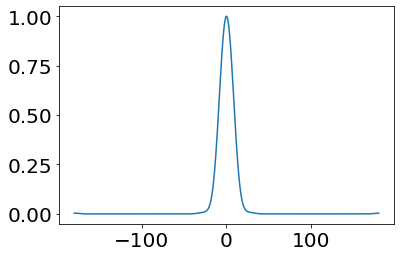

In [44]:
data = func.csv_to_array("/data/ms2840a/other_data/Aeff/Aeff_gain.csv")
W = np.concatenate([np.flip(data["20GHz0deg"]), data["20GHz0deg"][1:]], 0)
theta = np.concatenate([np.flip(data["theta"]) * -1, data["theta"][1:]], 0)
plt.plot(theta, np.power(10, W/10)/np.max(np.power(10, W/10)), label=freq[:2] + " GHz")

In [52]:
theta = np.radians(np.linspace(0, 180, 1801))
value = np.cos(theta)**2 * np.sin(theta)
integral(theta, value)

0.0003189103617827599

In [51]:
theta = np.radians(np.linspace(0, 180, 1801))
value = np.cos(theta)**2 * np.sin(theta)
print(integrate.simps(value, theta))

0.6666666666673883


In [95]:
L = 1.0865 # [m] the length between anntena and window
radius = 0.105 # [m] the radius of window
theta_win = np.degrees(np.arctan(radius/L)) # [deg]

result = 0
for i in range(1800):
    t = (theta[i]+theta[i+1])/2
    result += np.cos(t)**2 * np.sin(t) * np.radians(0.1)
    
print(result)
print(my_func(data["theta"], np.cos(np.radians(data["theta"]))))
print(integral(data["theta"], np.cos(np.radians(data["theta"]))))
print(my_func(data["theta"], np.ones(1801)))
print(integral(data["theta"], np.ones(1801)))

print("")
_v = np.power(10, data["20GHz0deg"]/10)/np.max(np.power(10, data["20GHz0deg"]/10))
_t = data["theta"]

print("A eff")
_C = np.pi * 0.00174**2 * 3 / 1.085**2 / 0.015**2 / np.sqrt(2 * np.log(2))
_sin = np.sin(np.radians(20 / np.sqrt(2 * np.log(2))))
_integral = integral(_t, _v * np.radians(_t**2))
print(_C)
print(_sin)
print(_integral)
print(_C * _sin * _integral)
print(2.01/1.74)

print("")
print("e win")
_C = np.pi * 0.00174 * 3 / 1.085**2 / 0.015**2 / np.sqrt(2 * np.log(2))
_sin = np.sin(np.radians(20 / np.sqrt(2 * np.log(2))))
_integral_A = integral(_t, _v * np.radians(_t**2))
_integral_win = integral(_t[:int(theta_win*10)], _v[:int(theta_win*10)] * np.radians(_t[:int(theta_win*10)]**2))
print(_C)
print(_sin)
print(_integral_A)
print(_integral_win)
print(_C * _sin * (_integral_win - _integral_A * 0.2))
print(0.22265/0.2)


0.6666669205146726
0.6666664128189118
0.0
2.0000002538478707
2.000000000000103

A eff
0.09149553504551904
0.29214530442578124
0.07738711796502587
0.0020685569620370616
1.1551724137931034

e win
52.58364083075807
0.29214530442578124
0.07738711796502587
0.0009836925485434875
-0.22265362040092984
1.1132499999999999


In [111]:
((100 + (6.9**2+15.5**2+11.3**2+7.7**2+1.5**2)**0.5)/100)**0.5

1.1038224040991416

2.0000002538478707


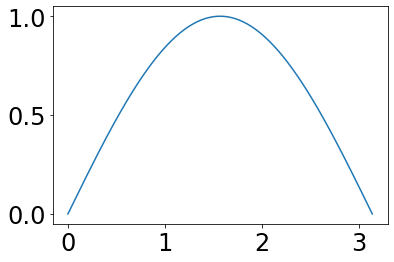

In [250]:
result = 0
for i in range(1800):
    t = (theta[i]+theta[i+1])/2
    result += np.sin(t) * np.radians(0.1)
    
print(result)
plt.plot(theta, np.sin(theta))

1.9999999999999998


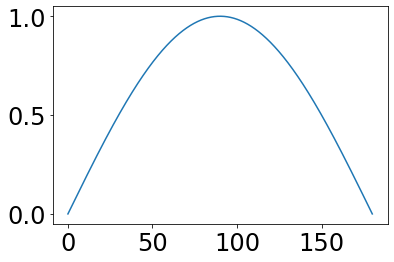

In [238]:
xx = np.linspace(0, 180, 18001)
yy = np.sin(np.radians(xx))
print(integrate.simps(yy, np.radians(xx)))
plt.plot(xx, yy)

In [27]:
def its(text):
    if int(text) < 0:
        return "m" + str(int(text))[1:]
    elif int(text) > 0:
        return "p" + str(int(text))
    else:
        return "0"

In [28]:
def fit_gauss_func(x, height, mean, sigma):
    return height * np.exp(-(x-mean)**2/(2*sigma**2))

def residual_gauss(params, x, y, ye):
    height = params["height"]
    mean = params["mean"]
    sigma = params["sigma"]
    y_model = fit_gauss_func(x, height, mean, sigma)
    chi = (y - y_model)/ye
    o = np.isfinite(chi)
    return chi[o]

def fit_gauss(x, y, ye):    
    params = lmfit.Parameters()
    params.add("height", value=1.e-5)
    params.add("mean", value=1.)
    params.add("sigma", value=10.)

    result = lmfit.minimize(residual_gauss, params, args=(x, y, ye))
    height = result.params["height"].value
    height_err = result.params["height"].stderr
    mean = result.params["mean"].value
    mean_err = result.params["mean"].stderr
    sigma = result.params["sigma"].value
    sigma_err = result.params["sigma"].stderr

    #print("height = " + str(round(height, 6)) + " +/- " + str(round(height_err, 6)))
    #print("sigma = " + str(round(sigma, 6)) + " +/- " + str(round(sigma_err, 6)))
    HPBW = 2 * np.degrees(np.arctan(sigma/(L*100))) * np.sqrt(2 * np.log(2)) * np.sqrt(2)
    HPBW_err = 2 * 1/(1+(sigma/(L*100))**2) * np.sqrt(2 * np.log(2)) * np.sqrt(2)
    print("HPBW = " + str(round(HPBW, 6)) + " +/- " + str(round(HPBW_err, 6)))
    #print(result.success)
    #print(result.redchi)
    
    return HPBW, HPBW_err

In [29]:
rrr = {"10": 2}
print("10" in rrr)

True


In [25]:
def get_peak(freq):
    _p = "/data/ms2840a/other_data/Aeff/data/Aeff_"
    step = np.linspace(-40, 40, 81)
    
    result = {}

    for i in step:
        max_value = 0.
        std_value = 0.
        for j in step:
            path0 = _p + its(i) + "_" + its(j) + "_{}GHz_0.dat".format(freq)
            path1 = _p + its(i) + "_" + its(j) + "_{}GHz_1.dat".format(freq)
            r = str(int(i**2 + j**2))
            if os.path.exists(path0):
                _f0, _W0 = func.dat_to_array(path0)
                _f1, _W1 = func.dat_to_array(path1)
                if r in result:
                    result[r].append(np.max(func.dat_to_array(path0)[1]))
                    result[r].append(np.max(func.dat_to_array(path1)[1]))
                else:
                    result[r] = [
                        np.max(func.dat_to_array(path0)[1]), 
                        np.max(func.dat_to_array(path1)[1])
                    ]
    
    return result

def get_peak_0(freq):
    _p = "/data/ms2840a/other_data/Aeff/data/Aeff_"
    step = np.linspace(-40, 40, 81)
    
    x = np.array([])
    Wx = np.array([])
    Wxstd = np.array([])
    for i in step:
        max_value = 0.
        std_value = 0.
        for j in step:
            if j != 0: continue
            path0 = _p + its(i) + "_" + its(j) + "_{}GHz_0.dat".format(freq)
            path1 = _p + its(i) + "_" + its(j) + "_{}GHz_1.dat".format(freq)
            if os.path.exists(path0):
                _f0, _W0 = func.dat_to_array(path0)
                _f1, _W1 = func.dat_to_array(path1)
                if max_value < np.mean([np.max(_W0), np.max(_W1)]):
                    max_value = np.mean([np.max(_W0), np.max(_W1)])
                    std_value = np.std([np.max(_W0), np.max(_W1)])

        if max_value != 0:
            x = np.append(x, i)
            Wx = np.append(Wx, max_value)
            Wxstd = np.append(Wxstd, std_value)
            
    y = np.array([])
    Wy = np.array([])
    Wystd = np.array([])
    for i in step:
        max_value = 0.
        std_value = 0.
        for j in step:
            if j != 0: continue
            path0 = _p + its(j) + "_" + its(i) + "_{}GHz_0.dat".format(freq)
            path1 = _p + its(j) + "_" + its(i) + "_{}GHz_1.dat".format(freq)
            if os.path.exists(path0):
                _f0, _W0 = func.dat_to_array(path0)
                _f1, _W1 = func.dat_to_array(path1)
                if max_value < np.mean([np.max(_W0), np.max(_W1)]):
                    max_value = np.mean([np.max(_W0), np.max(_W1)])
                    std_value = np.std([np.max(_W0), np.max(_W1)])

        if max_value != 0:
            y = np.append(y, i)
            Wy = np.append(Wy, max_value)
            Wystd = np.append(Wystd, std_value)
            
    
    return x, Wx, Wxstd, y, Wy, Wystd

/home/dosue/test/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dosue/test/lib/python3.8/site-packages/matplotlib/axes/_base.py:2475: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
/home/dosue/test/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dosue/test/lib/python3.8/site-packages/matplotlib/axes/_base.py:2475: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
/home/dosue/test/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dosue/test/lib/python3.8/site-packages/matplotlib/axes/_base.py:2475: UserWarning: Warning: converting a masked element to nan.
 

Text(0.5, 0, 'Radius [cm]')

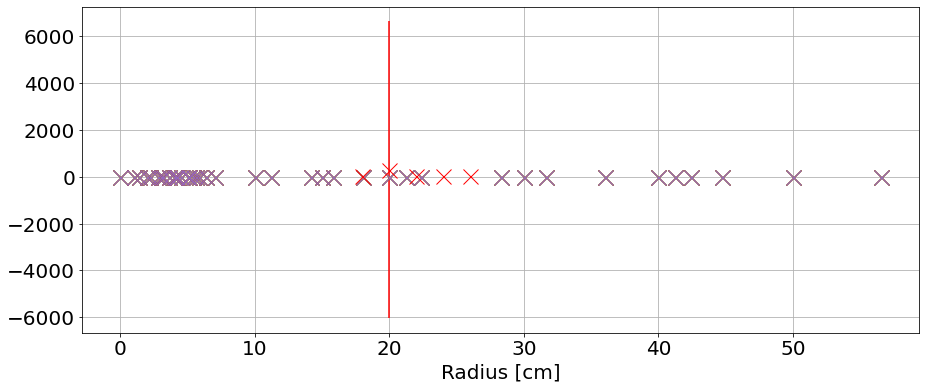

In [37]:
plt.rcParams["font.size"] = 20
plt.figure(figsize=(15,6))

for i in np.linspace(18, 26, 5):
    result = get_peak(int(i))

    r = np.zeros(0)
    W = np.zeros(0)
    Werr = np.zeros(0)
    for rr, WW in result.items():
        r = np.append(r, float(rr)**0.5)
        W = np.append(W, np.mean(WW))
        Werr = np.append(Werr, np.std(Werr))

    plt.errorbar(r, W, yerr=Werr, capsize=0, fmt='x', markersize=15, label="measurement")

plt.errorbar(freq_measure, hpbw_measure, yerr=hpbw_e_measure, capsize=0, fmt='x', markersize=15, 
             ecolor='red', markeredgecolor = "red", color='red', label="measurement")


#HH, HHe = fit_gauss(r, W, Werr)

plt.grid()
plt.xlabel("Radius [cm]")

In [1]:
plt.rcParams["font.size"] = 20
plt.figure(figsize=(15,6))

color = "green"
plt.errorbar(freq_measure, hpbw_x, yerr=hpbw_x_err, capsize=5, fmt='x', markersize=15, 
             ecolor=color, markeredgecolor=color, color=color, label="axis x")
color = "red"
plt.errorbar(freq_measure, hpbw_y, yerr=hpbw_y_err, capsize=5, fmt='x', markersize=15, 
             ecolor=color, markeredgecolor=color, color=color, label="axis y")
#plt.scatter(point, hpbw_sim, label="simulation", marker="x", s=200, color="blue")
plt.plot(point, hpbw_sim, label="simulation", color="blue")
plt.legend(loc="upper right", fontsize=20)
plt.grid()
plt.title("Half Power Beam Width")
plt.ylim([0,30])
plt.ylabel(r"$\theta_{1/2}$ [deg]")
plt.xlabel("Frequency [GHz]")
plt.savefig("../result_figure/A_eff/HPBW_compare.pdf")

NameError: name 'plt' is not defined

In [22]:
check = np.abs(np.array([
    (hpbw_sim[0]-hpbw_x[0])/hpbw_sim[0], 
    (hpbw_sim[2]-hpbw_x[1])/hpbw_sim[2], 
    (hpbw_sim[4]-hpbw_x[2])/hpbw_sim[4],
    (hpbw_sim[6]-hpbw_x[3])/hpbw_sim[6], 
    (hpbw_sim[8]-hpbw_x[4])/hpbw_sim[8], 
    (hpbw_sim[0]-hpbw_y[0])/hpbw_sim[0], 
    (hpbw_sim[2]-hpbw_y[1])/hpbw_sim[2], 
    (hpbw_sim[4]-hpbw_y[2])/hpbw_sim[4], 
    (hpbw_sim[6]-hpbw_y[3])/hpbw_sim[6], 
    (hpbw_sim[8]-hpbw_y[4])/hpbw_sim[8]
]))
print(np.std(check))

check1 = np.std(np.abs(np.array([hpbw_sim[0]-hpbw_x[0], hpbw_sim[0]-hpbw_y[0]])))/hpbw_sim[0]
check2 = np.std(np.abs(np.array([hpbw_sim[2]-hpbw_x[1], hpbw_sim[2]-hpbw_y[1]])))/hpbw_sim[2]
check3 = np.std(np.abs(np.array([hpbw_sim[4]-hpbw_x[2], hpbw_sim[4]-hpbw_y[2]])))/hpbw_sim[4]
check4 = np.std(np.abs(np.array([hpbw_sim[6]-hpbw_x[3], hpbw_sim[6]-hpbw_y[3]])))/hpbw_sim[6]
check5 = np.std(np.abs(np.array([hpbw_sim[8]-hpbw_x[4], hpbw_sim[8]-hpbw_y[4]])))/hpbw_sim[8]
print(np.std([check1, check2, check3, check4, check5]))

NameError: name 'hpbw_x' is not defined

In [23]:
Omega_A = []
for freq in ["18GHz", "19GHz", "20GHz", "21GHz", "22GHz", "23GHz", "24GHz", "25GHz", "26GHz"]:
    W = 10**(data[freq+"0deg"]/10)
    Omega_A.append(integral(data["theta"], (W/np.max(W))) * 2 * np.pi)
    
xxx = np.linspace(0, 180, 1801)
Omega_A_x = []
for _h in hpbw_x:
    W = fit_gauss_func(xxx, 1, _h/2/np.sqrt(2*np.log(2)))
    Omega_A_x.append(integral(data["theta"], (W/np.max(W))) * 2 * np.pi)
    
Omega_A_y = []
for _h in hpbw_y:
    W = fit_gauss_func(xxx, 1, _h/2/np.sqrt(2*np.log(2)))
    Omega_A_y.append(integral(data["theta"], (W/np.max(W))) * 2 * np.pi)
        
A_antenna = np.pi * (59.3/2*1e-3)**2
c = 299792458. # [m/sec] speed of light from wikipedia
eta = (c/(point*1e+9))**2/np.array(Omega_A)/A_antenna
eta_x = (c/(freq_measure*1e+9))**2/np.array(Omega_A_x)/A_antenna
eta_y = (c/(freq_measure*1e+9))**2/np.array(Omega_A_y)/A_antenna

plt.figure(figsize=(15,6))
plt.scatter(point, eta, marker="x", s=200, color="green", label="simulation")
plt.scatter(freq_measure, eta_x, marker="x", s=200, color="red", label="axis x")
plt.scatter(freq_measure, eta_y, marker="x", s=200, color="blue", label="axis y")

print(np.mean(eta), np.std(eta))
#plt.text(24.1, 0.25, r"$\eta$ = " + str(round(np.mean(eta), 2)) + r"$\pm$" + str(round(np.std(eta),2)))
#plt.plot([18, 26], [0.629, 0.629], color="red", label="constant")

plt.grid()
plt.legend()
plt.xlabel("Frequency [GHz]")
plt.title(r"$\eta = A_{\rm eff}/A$")
#plt.ylim([0,1])
#plt.savefig("../result_figure/A_eff/eta_fit.pdf")

NameError: name 'hpbw_x' is not defined